In this project, we are working as data scientists for an NBA team, analyzing player data from the 2023-2024 regular season to identify new player archetypes that reflect the evolving roles in modern basketball. Instead of using the traditional positions like Point Guard or Center, we came up with five distinct character tropes based on player behaviors and performance statistics. These archetypes include the Risk Taker, who attempts the most 2-pointers, 3-pointers, and steals; the MVP, representing the player who scores the most points (the "King" of scoring); the BFF, focused on players with the most assists, blocks, personal fouls, and turnovers; the Marathon Runner, players who spend the most time in games; and finally, players who rank highly in each of these categories. Our goal is to use these archetypes as flexible, data-driven representations of player behavior in today's game.

## Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score, f1_score
from sklearn.manifold import TSNE

print("All imports successful!")

All imports successful!


In [6]:
import os

# Load data function
def load_data(file_name, local_path, server_path, encoding='utf-8', sep=','):
    data = None
    local_path = local_path.rstrip('\\') + '\\'
    server_path = server_path.rstrip('/') + '/'

    try:
        # Attempt to load from the local path
        file_path = os.path.join(local_path, file_name)
        print(f"Attempting to load file from local path: {file_path}")
        data = pd.read_csv(file_path, encoding=encoding, sep=sep)
        print(f"'{file_name}' successfully loaded from the local path.")
    except FileNotFoundError:
        print(f"'{file_name}' not found in local path. Trying server path.")
        try:
            file_path = os.path.join(server_path, file_name)
            print(f"Attempting to load file from server path: {file_path}")
            data = pd.read_csv(file_path, encoding=encoding, sep=sep)
            print(f"'{file_name}' successfully loaded from the server path.")
        except FileNotFoundError:
            print(f"'{file_name}' file not found in both local and server paths.")
        except UnicodeDecodeError:
            print(f"Encoding error encountered while reading '{file_name}' from the server path.")
    except UnicodeDecodeError:
        print(f"Encoding error encountered while reading '{file_name}' from the local path.")

    return data

# Paths and file
file_name = '2023-2024 NBA Player Stats - Regular.csv'
local_path = r'C:\Users\betak\NBA-Archetypes\datasets'  
server_path = '/datasets'  

# Load data
data = load_data(file_name, local_path, server_path, encoding='ISO-8859-1', sep=';')

if data is not None:
    print("Data loaded successfully. Here's a preview:")
    print(data.head())  
else:
    print("Data could not be loaded. Please check the file paths or formats.")

Attempting to load file from local path: C:\Users\betak\NBA-Archetypes\datasets\2023-2024 NBA Player Stats - Regular.csv
'2023-2024 NBA Player Stats - Regular.csv' successfully loaded from the local path.
Data loaded successfully. Here's a preview:
   Rk            Player   Pos  Age   Tm   G  GS    MP   FG   FGA  ...    FT%  \
0   1  Precious Achiuwa  PF-C   24  TOT  74  18  21.9  3.2   6.3  ...  0.616   
1   1  Precious Achiuwa     C   24  TOR  25   0  17.5  3.1   6.8  ...  0.571   
2   1  Precious Achiuwa    PF   24  NYK  49  18  24.2  3.2   6.1  ...  0.643   
3   2       Bam Adebayo     C   26  MIA  71  71  34.0  7.5  14.3  ...  0.755   
4   3      Ochai Agbaji    SG   23  TOT  78  28  21.0  2.3   5.6  ...  0.661   

   ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0  2.6  4.0   6.6  1.3  0.6  0.9  1.1  1.9   7.6  
1  2.0  3.4   5.4  1.8  0.6  0.5  1.2  1.6   7.7  
2  2.9  4.3   7.2  1.1  0.6  1.1  1.1  2.1   7.6  
3  2.2  8.1  10.4  3.9  1.1  0.9  2.3  2.2  19.3  
4  0.9  1.8   2

Rk : Rank

Player : Player's name

Pos : Position

Age : Player's age

Tm : Team

G : Games played

GS : Games started

MP : Minutes played per game

FG : Field goals per game

FGA : Field goal attempts per game

FG% : Field goal percentage

3P : 3-point field goals per game

3PA : 3-point field goal attempts per game

3P% : 3-point field goal percentage

2P : 2-point field goals per game

2PA : 2-point field goal attempts per game

2P% : 2-point field goal percentage

eFG% : Effective field goal percentage

FT : Free throws per game

FTA : Free throw attempts per game

FT% : Free throw percentage

ORB : Offensive rebounds per game

DRB : Defensive rebounds per game

TRB : Total rebounds per game

AST : Assists per game

STL : Steals per game

BLK : Blocks per game

TOV : Turnovers per game

PF : Personal fouls per game

PTS : Points per game

In [13]:
columns_to_drop = [
    'Rk', 'Player', 'Pos', 'Tm',   # Descriptive columns
    'FG%', '3P%', '2P%', 'eFG%', 'FT%',  # Percentage columns
    'TRB'  # Totals column
]

# Drop the columns
filtered_data = data.drop(columns=columns_to_drop)

print(filtered_data.head())  # Display the first few rows

   Age   G  GS    MP   FG   FGA   3P  3PA   2P   2PA   FT  FTA  ORB  DRB  AST  \
0   24  74  18  21.9  3.2   6.3  0.4  1.3  2.8   5.0  0.9  1.5  2.6  4.0  1.3   
1   24  25   0  17.5  3.1   6.8  0.5  1.9  2.6   4.9  1.0  1.7  2.0  3.4  1.8   
2   24  49  18  24.2  3.2   6.1  0.3  1.0  2.9   5.1  0.9  1.4  2.9  4.3  1.1   
3   26  71  71  34.0  7.5  14.3  0.2  0.6  7.3  13.7  4.1  5.5  2.2  8.1  3.9   
4   23  78  28  21.0  2.3   5.6  0.8  2.7  1.5   2.8  0.5  0.7  0.9  1.8  1.1   

   STL  BLK  TOV   PF   PTS  
0  0.6  0.9  1.1  1.9   7.6  
1  0.6  0.5  1.2  1.6   7.7  
2  0.6  1.1  1.1  2.1   7.6  
3  1.1  0.9  2.3  2.2  19.3  
4  0.6  0.6  0.8  1.5   5.8  


In [14]:
filtered_data.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT',
       'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

## EDA:

In [17]:
print(filtered_data.describe())


              Age           G          GS          MP          FG         FGA  \
count  735.000000  735.000000  735.000000  735.000000  735.000000  735.000000   
mean    26.155102   40.880272   18.440816   18.264762    2.972789    6.423401   
std      4.371745   25.581293   25.024108    9.735524    2.356999    4.783384   
min     19.000000    1.000000    0.000000    0.500000    0.000000    0.000000   
25%     23.000000   17.000000    0.000000   10.600000    1.300000    3.000000   
50%     25.000000   41.000000    5.000000   17.200000    2.300000    5.000000   
75%     29.000000   64.500000   29.000000   26.450000    4.150000    8.700000   
max     39.000000   84.000000   82.000000   37.800000   11.500000   23.600000   

               3P         3PA          2P         2PA          FT         FTA  \
count  735.000000  735.000000  735.000000  735.000000  735.000000  735.000000   
mean     0.909116    2.582449    2.062721    3.840408    1.170884    1.509252   
std      0.848969    2.1666

c:\Users\betak\projects\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


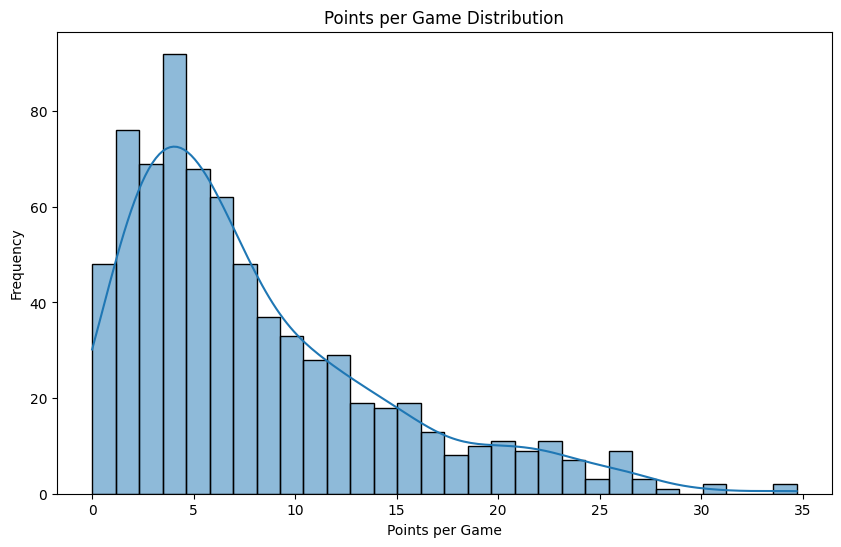

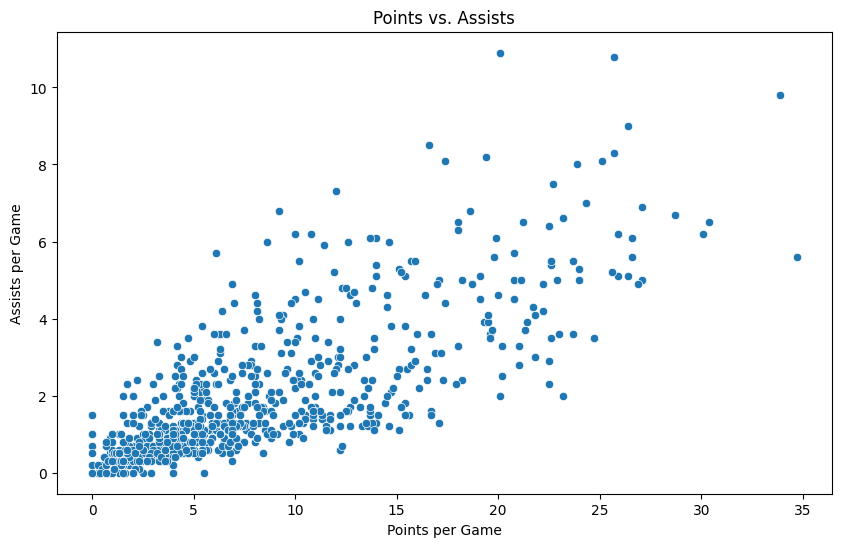

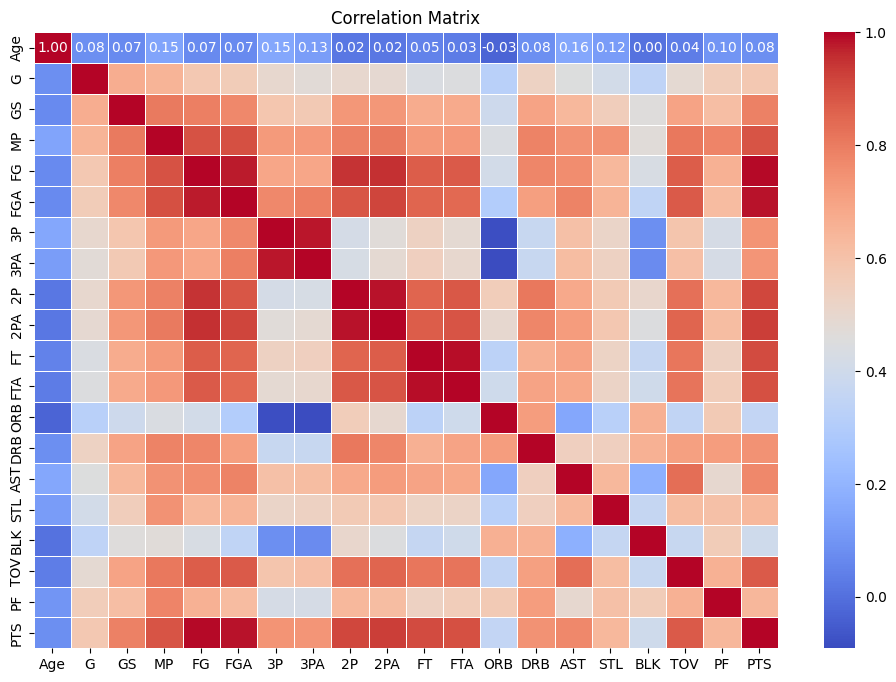

c:\Users\betak\projects\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\betak\projects\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\betak\projects\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\betak\projects\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

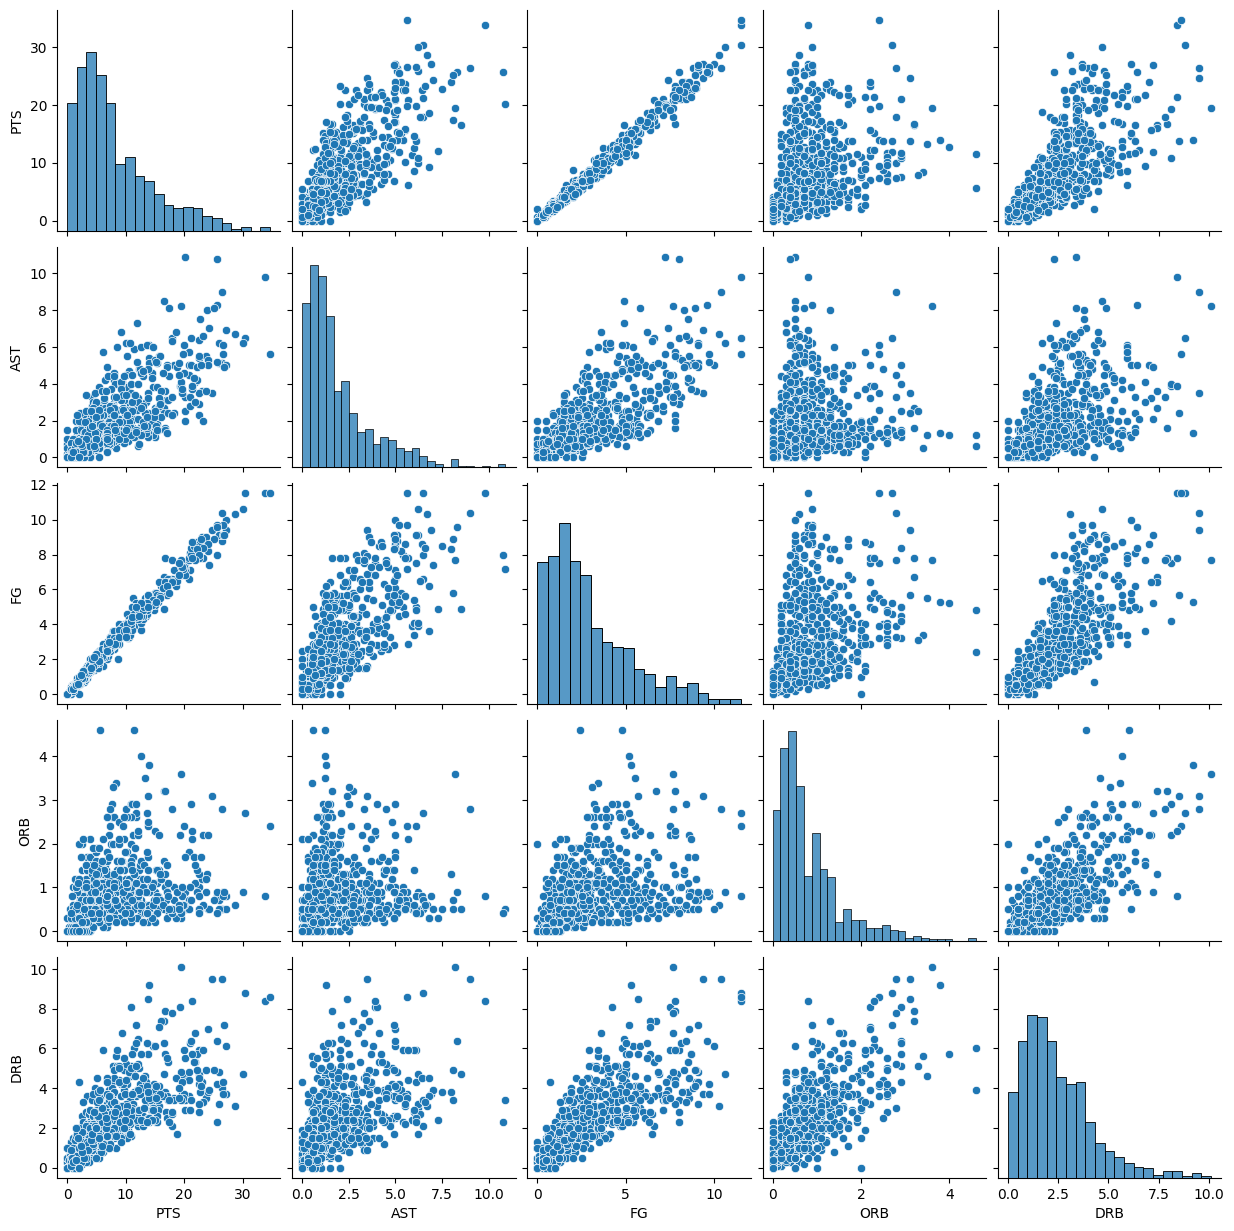

In [21]:
filtered_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Data Distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['PTS'], bins=30, kde=True)
plt.title('Points per Game Distribution')
plt.xlabel('Points per Game')
plt.ylabel('Frequency')
plt.show()

# Scatter plot for some key features (e.g., Points vs. Assists, Points vs. Rebounds)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PTS', y='AST', data=filtered_data)
plt.title('Points vs. Assists')
plt.xlabel('Points per Game')
plt.ylabel('Assists per Game')
plt.show()

# Correlation Matrix
correlation_matrix = filtered_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Pairplot of several features to look for relationships (e.g., PTS, AST, FG, ORB, DRB)
sns.pairplot(filtered_data[['PTS', 'AST', 'FG', 'ORB', 'DRB']])
plt.show()

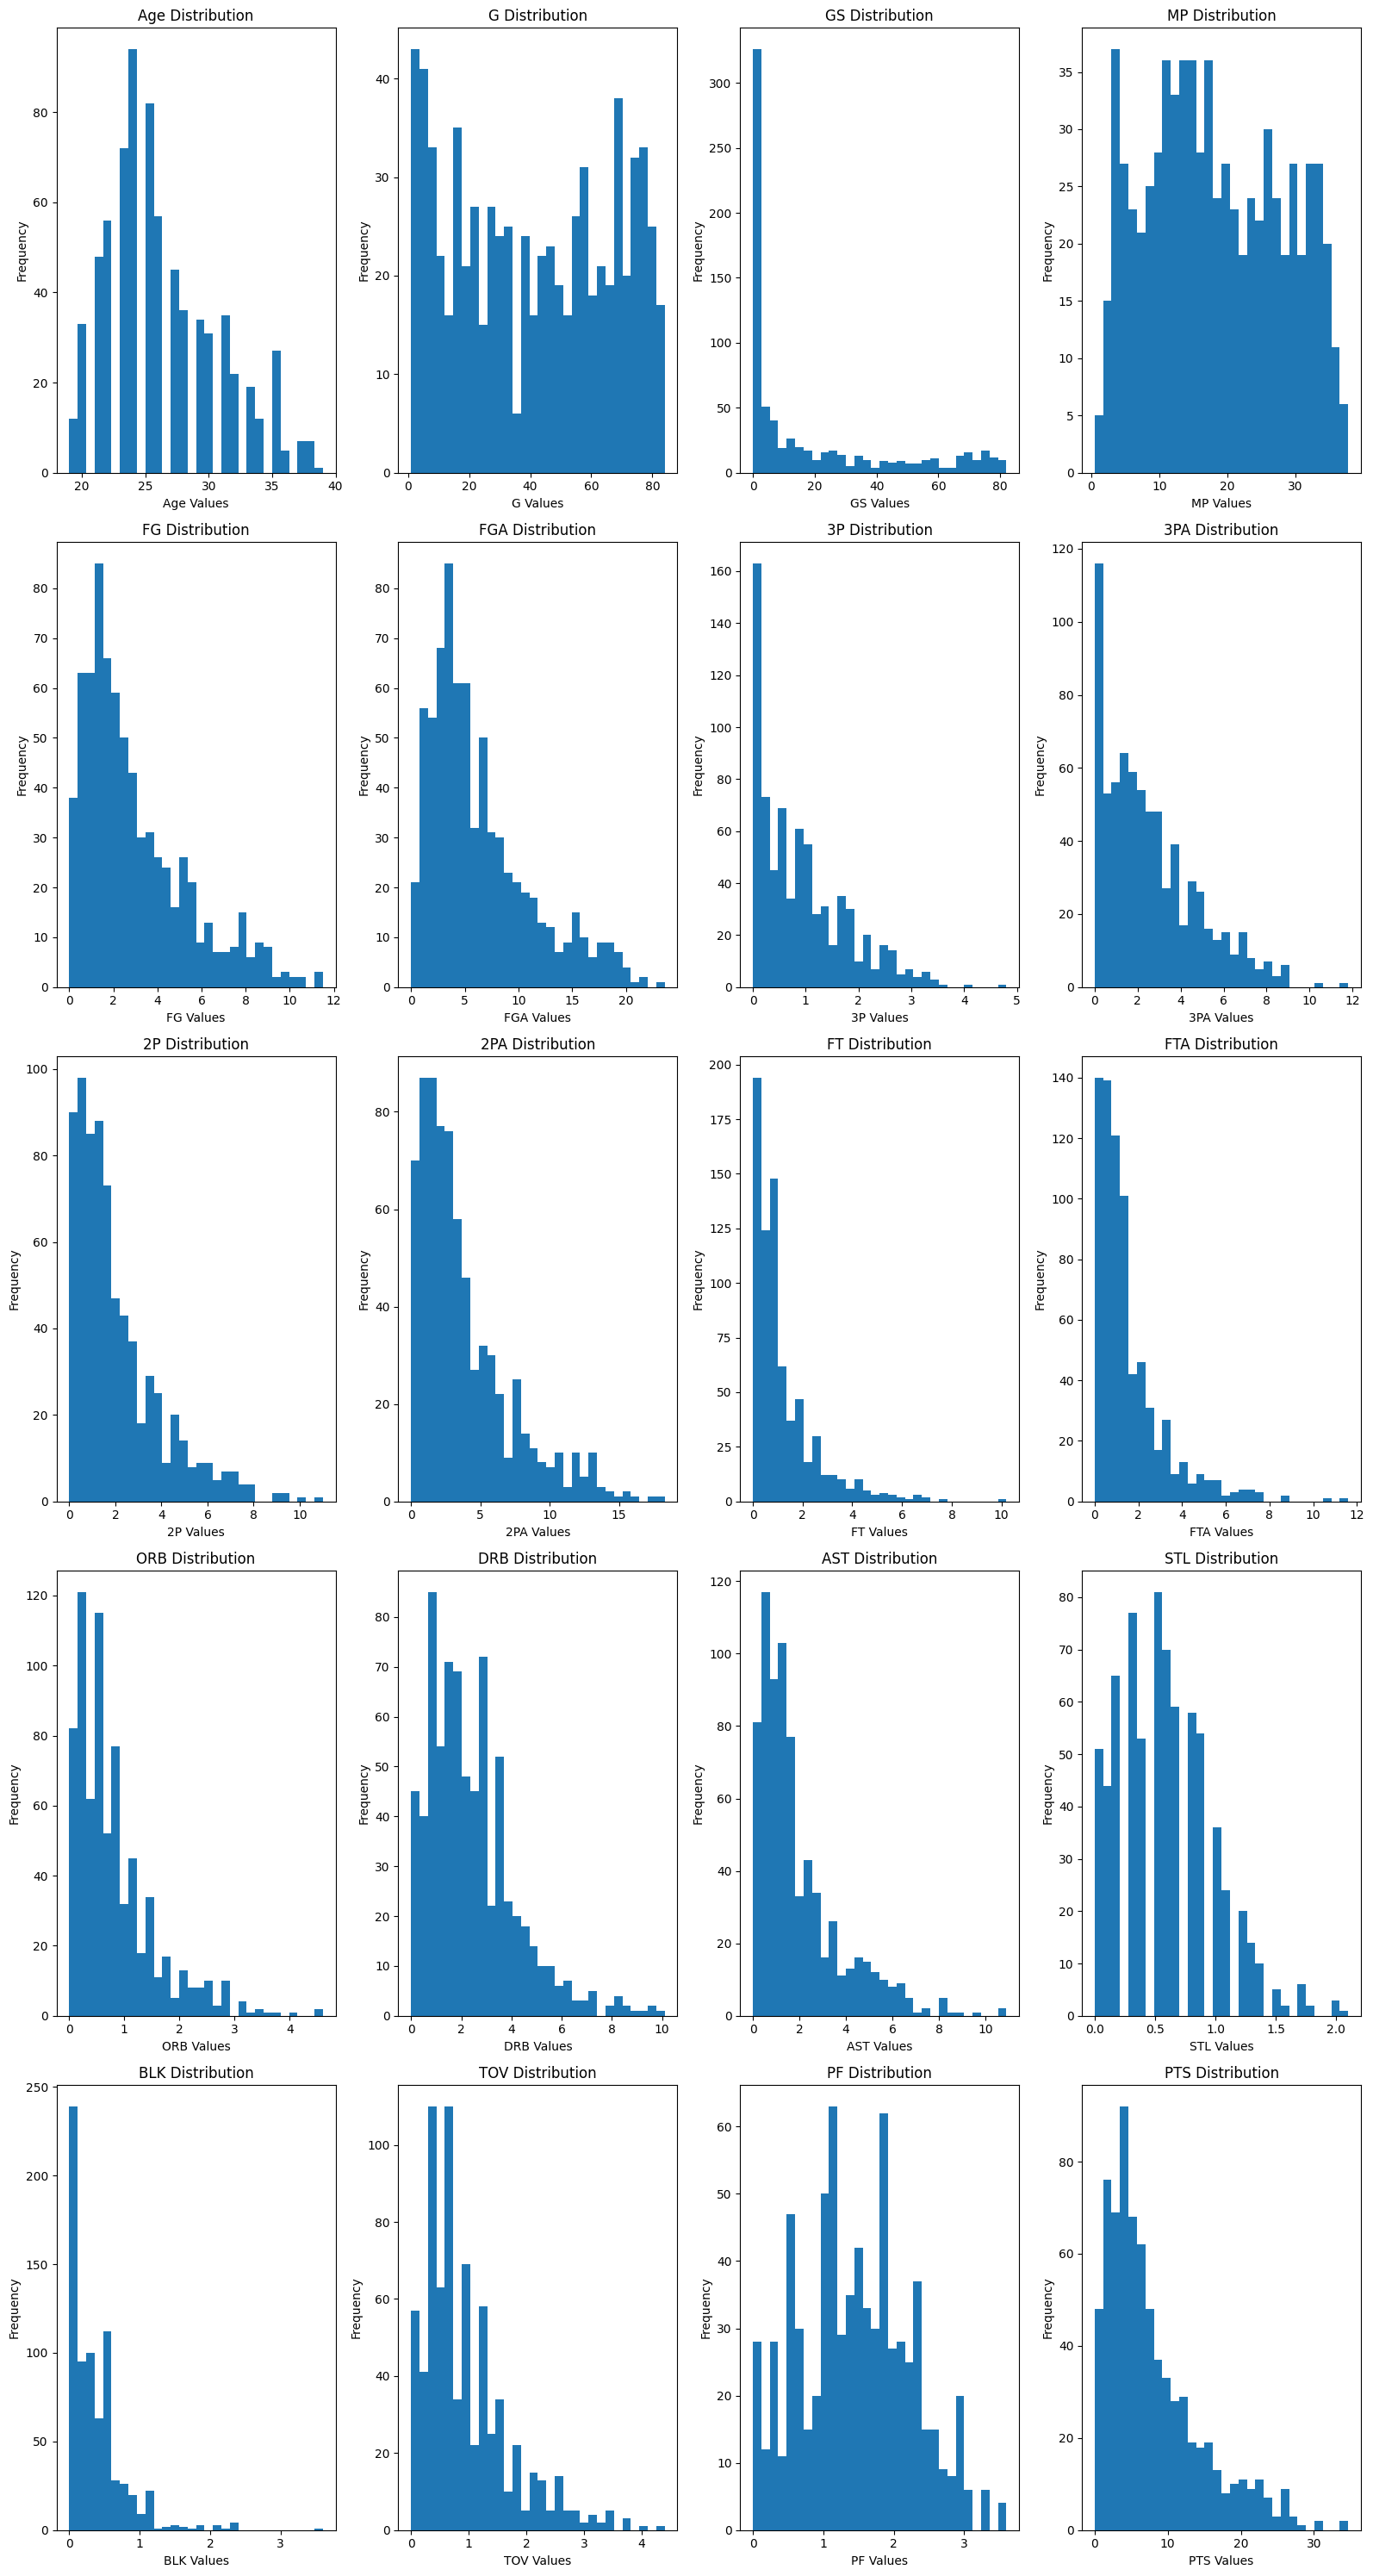

In [ ]:
num_cols = len(filtered_data.columns)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)  # Adjust rows based on number of columns

fig, axes = plt.subplots(num_rows, 4, figsize=(16, 6*num_rows))  # Adjust the grid size

axes = axes.flatten()

for i, col in enumerate(filtered_data.columns):
    axes[i].hist(filtered_data[col], bins=30)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(f'{col} Values')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()